In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import pylab
import math
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
np.random.seed(12345)

### Stats:
    Total images: 8256
    Without annotations: 5050
    With annotations: 3206
    Contain tiny1: 1012
    Contain tiny2: 1387
    Contain tiny3: 1608
    Contain others: 1921

In [5]:
data_dir = "../dataset/tiny_set/erase_with_uncertain_dataset"
train_file = f'{data_dir}/annotations/corner/task/tiny_set_train_sw640_sh512_all.json'
train_file_aug = f'{data_dir}/annotations/corner/task/tiny_set_train_sw640_sh512_all_augmented.json'
train_tiny3_and_others_file = f'{data_dir}/annotations/corner/task/tiny_set_train_sw640_sh512_tiny3_and_others.json'

### First, generate new annotation file that "ignore" all annotations except tiny 3 and larger (others)

In [ ]:
with open(train_file) as f:
    train = json.load(f)

annotations = train['annotations']
images = train['images']

# ignore 
for a in annotations:
    if a['size'] <= 12:
        a['ignore'] = True

removed_images = []
remaining_images = []

for img in images:
    found_bbox = False
    for a in annotations:
        if a['image_id'] == img['id'] and not a['ignore']:
            found_bbox = True
            break
    if not found_bbox:
        removed_images.append(img)
    else:
        remaining_images.append(img)

train['images'] = remaining_images

with open(train_tiny3_and_others_file, 'w') as f:
    json.dump(train, f)

### Augmentation
#### Before proceeding, all the images from f"{data_dir}/train_augmented/ should be deleted.

In [4]:
# a convenient method to create new annotation object
def new_ann(x, y, w, h, img_id):
    return {
        'segmentation': [[x, y, x, y + h, x + w, y + h, x + w, y]],
        'bbox': [x, y, w, h],
        'area': 0,
        'iscrowd': 0,
        'category_id': 1,
        'image_id': img_id,
        'ignore': False,
        'uncertain': False,
        'logo': False,
        'in_dense_image': False,
        'size': np.sqrt(w * h),
    }

In [6]:
# Given a crop (corner), existing annotations in the crop, this method tries to find a "good" location to place the "new tiny person"

def find_location(corner, tiny_persons, new_person):
    x = np.random.randint(0, corner[2] - corner[0] - new_person.width)
    y = np.random.randint(0, corner[3] - corner[1] - new_person.height)
    return x, y

In [7]:
# Given the original image, the current corner, a list of generated tiny persons, a list of existing annotations, this method tries to sample from tiny_persons 
# and randomly place them on the crop

def place_random(orig_img, file_name, corner, tiny_persons, existing_anns, max_objs=20):
    if os.path.exists(f"{data_dir}/train_augmented/{file_name}"):
        orig_img = Image.open(f"{data_dir}/train_augmented/{file_name}").convert('RGB')

    num_to_put = max(0, max_objs - len(existing_anns))

    if num_to_put == 0:
        return
    img_id = existing_anns[0]['image_id']
    anns = []

    patches = np.random.choice(list(range(len(tiny_persons))), num_to_put, replace=True)
    for p in patches:
        person = tiny_persons[p]
        x, y = find_location(corner, tiny_persons, person)
        ann = new_ann(x, y, person.width, person.height, img_id)
        anns.append(ann)
        orig_img.paste(person, (x + corner[0], y + corner[1]))

    orig_img.save(f"{data_dir}/train_augmented/{file_name}")

    return anns

### The main process

In [ ]:
with open(train_tiny3_and_others_file) as f:
    train_tiny3_and_others = json.load(f)
with open(train_file) as f:
    train = json.load(f)

new_anns = []
images = train_tiny3_and_others['images']
coco = COCO(train_tiny3_and_others_file)

for i in images:
    ann_ids = coco.getAnnIds(imgIds=i['id'])

    original_img = Image.open(f"{data_dir}/train/{i['file_name']}").convert('RGB')
    cropped_img = original_img.crop(i['corner'])
    anns = coco.loadAnns(ann_ids)

    tinified_persons = []

    for a in anns:
        if a['ignore']:
            continue
        bbox = a['bbox']
        
        p = cropped_img.crop([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]) # the big person
        
        tiny_p = tinify(p, a['size']) # make him tiny
        
        tinified_persons.append(tiny_p) 

    if len(tinified_persons) > 0:
        results = place_random(original_img, i['file_name'], i['corner'], tinified_persons, anns) # from the list of tinified persons, place some randomly on the original image
        if results is not None:
            new_anns.extend(results)

annotations = train['annotations']
idx = len(annotations)
for a in new_anns:
    a['id'] = idx
    idx = idx + 1

annotations.extend(new_anns)
with open(train_file_aug, 'w') as f:
    json.dump(train, f)

### Visualize the result

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


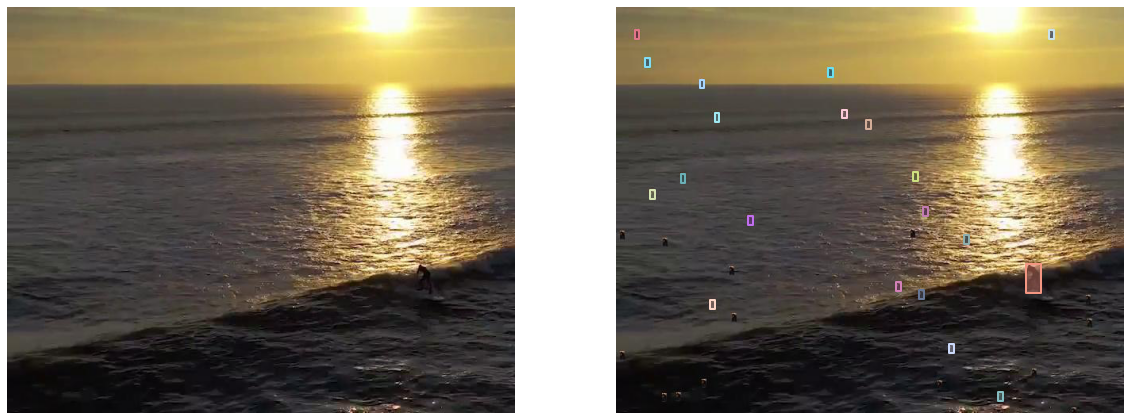

In [7]:
# initialize COCO api for instance annotations
coco=COCO(train_file_aug)

imgIds = coco.getImgIds(imgIds = [0])
img = coco.loadImgs(imgIds)[0]

img1 = Image.open(f"{data_dir}/train/{img['file_name']}").convert('RGB')
img1 = img1.crop(img['corner'])
img2 = Image.open(f"{data_dir}/train_augmented/{img['file_name']}").convert('RGB')
img2 = img2.crop(img['corner'])

fig = plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(img1)
fig.add_subplot(122)
plt.axis('off')
plt.imshow(img2)
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
plt.show()